In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

In [2]:
colspecs = [(0, 2),(2,10), (10,12),(12,24),(24,27),(27,39),(39,49),(49,52),(52,56),(56,69),(69,82),(82,95),(95,108),(108,121),(121,134),(134,147),(147,152),(152,170),(170,188),(188,201),(201,202),(202,210),(210,217),(217,230),(230,242),(242,-1)]

In [3]:
names = ['TIPREG','DATA','CODBDI','CODNEG','TPMERC','NOMRES','ESPECI','PRAZOT','MODREF','PREABE','PREMAX','PREMIN','PREMED','PREULT','PREOFC','PREOFV','TOTNEG','QUATOT','VOLTOT','PREEXE','INDOPC','DATVEN','FATCOT','PTOEXE','ISIN','DISMES'] 

In [4]:
# aqui importa o arquivo baixado da B3
# salvem o arquivo que vocês baixaram na mesma pasta que o .ipynb
# mudem o nome do arquivo aqui embaixo, substituindo 'COTAHIST_M072021.txt'
data = pd.read_fwf('COTAHIST_A2021.txt', header=None, skiprows=1, colspecs=colspecs, names=names)
data.head()

TIPREG      DATA  CODBDI  CODNEG  TPMERC        NOMRES ESPECI  PRAZOT  \
0       1  20210104     2.0  A1AP34      10  ADVANCE AUTO    DRN     NaN   
1       1  20210104     2.0  A1BB34      10       ABB LTD    DRN     NaN   
2       1  20210104     2.0  A1BM34      10   ABIOMED INC    DRN     NaN   
3       1  20210104     2.0  A1CR34      10     AMCOR PLC    DRN     NaN   
4       1  20210104     2.0  A1EE34      10   AMEREN CORP    DRN     NaN   

  MODREF   PREABE  ...  TOTNEG  QUATOT      VOLTOT  PREEXE  INDOPC  \
0     R$   5110.0  ...    22.0  6420.0  33355870.0     0.0     0.0   
1     R$   3680.0  ...    22.0    50.0    214670.0     0.0     0.0   
2     R$  40942.0  ...    19.0   320.0  13537960.0     0.0     0.0   
3     R$   5850.0  ...     4.0  1100.0   6592550.0     0.0     0.0   
4     R$  19960.0  ...     1.0   400.0   7984000.0     0.0     0.0   

       DATVEN  FATCOT  PTOEXE          ISIN  DISMES  
0  99991231.0     1.0     0.0  BRA1APBDR001   105.0  
1  99991231.0     1.0     0.0  BRA1BBBDR009   100.0  
2  99991231.0     1.0     0.0  BRA1BMBDR006   100.0  
3  99991231.0     1.0     0.0  BRA1CRBDR003   101.0  
4  99991231.0     1.0     0.0  BRA1EEBDR007   104.0  

[5 rows x 26 columns]

In [5]:
data_clean = data.loc[:, ['DATA','CODNEG','CODBDI','VOLTOT','PREABE','PREULT']]
data_clean['ANO'] = data_clean['DATA'].astype(str).str[0:4]
data_clean['MES'] = data_clean['DATA'].astype(str).str[4:6]
data_clean['PREABE'] = data_clean['PREABE'].div(100)
data_clean['PREULT'] = data_clean['PREULT'].div(100)
data_clean['VOLTOT'] = data_clean['VOLTOT'].div(100)
data_clean.loc[data_clean['CODNEG'] == 'FLRY3'].head()

DATA CODNEG  CODBDI      VOLTOT  PREABE  PREULT   ANO MES
1635  20210212  FLRY3     2.0  42973841.0   28.16   28.31  2021  02
1685  20210104  FLRY3     2.0  42972716.0   27.35   27.00  2021  01
4362  20210115  FLRY3     2.0  40083071.0   27.51   28.03  2021  01
6021  20210201  FLRY3     2.0  78779799.0   26.75   27.28  2021  02
7545  20210217  FLRY3     2.0  31994650.0   28.31   28.21  2021  02

In [6]:
# cria campo Preco de Fechamento do dia Anterior, buscando pela combinação de CODNEG, ANO e MES.
data_clean['PREULT_ANT'] = data_clean.groupby(['CODNEG','ANO','MES']).PREULT.shift(1)
# cria o campo Rentabilidade Diaria com duas condições
# 1)quando PREULT_ANT for NaN (not a number) ou 2)quando podemos utilizar PREULT_ANT
data_clean.loc[data_clean['PREULT_ANT'] == data_clean['PREULT_ANT'], 'RENT_D'] = (data_clean['PREULT'] - data_clean['PREULT_ANT']) / data_clean['PREULT_ANT']
data_clean.loc[data_clean['PREULT_ANT'] != data_clean['PREULT_ANT'], 'RENT_D'] = (data_clean['PREULT'] - data_clean['PREABE']) / data_clean['PREABE']
# cria o campo Multiplicador de Renda Diaria, somente somando 1
data_clean['MULT_RENT_D'] = data_clean['RENT_D'] + 1
# cria o campo de Rentabilidade Mensal, fazendo a multiplicação do MULT_RENT_D pela combinação de CODNEG, ANO e MES e retirando 1
data_clean['RENT_M'] = data_clean.groupby(['CODNEG','ANO','MES']).MULT_RENT_D.transform(np.prod) - 1
data_clean['RENT_A'] = data_clean.groupby(['CODNEG','ANO']).MULT_RENT_D.transform(np.prod) - 1
# cria o campo Volatilidade Mensal, calculando o Desvio Padrão da RENT_D pela combinação de CODNEG, ANO e MES
data_clean['VOLAT_M'] = data_clean.groupby(['CODNEG','ANO','MES']).RENT_D.transform(np.std)
data_clean['VOLAT_A'] = data_clean.groupby(['CODNEG','ANO']).RENT_D.transform(np.std)
# cria o acumulado do volume total de títulos movimentados no mês - será usado para filtrar apenas as maiores empresas.
data_clean['VOLTOT_A'] = data_clean.groupby(['CODNEG','ANO']).VOLTOT.transform(np.sum)

In [7]:
# visualizamos um exemplo de ação qualquer
data_clean.loc[data_clean['CODNEG'] == 'FLRY3']

DATA CODNEG  CODBDI      VOLTOT  PREABE  PREULT   ANO MES  \
1635    20210212  FLRY3     2.0  42973841.0   28.16   28.31  2021  02   
1685    20210104  FLRY3     2.0  42972716.0   27.35   27.00  2021  01   
4362    20210115  FLRY3     2.0  40083071.0   27.51   28.03  2021  01   
6021    20210201  FLRY3     2.0  78779799.0   26.75   27.28  2021  02   
7545    20210217  FLRY3     2.0  31994650.0   28.31   28.21  2021  02   
...          ...    ...     ...         ...     ...     ...   ...  ..   
939891  20211223  FLRY3     2.0  13789559.0   17.61   17.39  2021  12   
939892  20211227  FLRY3     2.0  13935549.0   17.38   17.59  2021  12   
939893  20211228  FLRY3     2.0  14734699.0   17.59   17.76  2021  12   
939894  20211229  FLRY3     2.0  16623069.0   17.81   17.65  2021  12   
939895  20211230  FLRY3     2.0  32458241.0   17.65   17.99  2021  12   

        PREULT_ANT    RENT_D  MULT_RENT_D    RENT_M   RENT_A   VOLAT_M  \
1635           NaN  0.005327     1.005327 -0.002486 -0.41691  0.034137   
1685           NaN -0.012797     0.987203 -0.039854 -0.41691  0.042553   
4362         27.00  0.038148     1.038148 -0.039854 -0.41691  0.042553   
6021         28.31 -0.036383     0.963617 -0.002486 -0.41691  0.034137   
7545         27.28  0.034091     1.034091 -0.002486 -0.41691  0.034137   
...            ...       ...          ...       ...      ...       ...   
939891       17.44 -0.002867     0.997133  0.019263 -0.41691  0.025912   
939892       17.39  0.011501     1.011501  0.019263 -0.41691  0.025912   
939893       17.59  0.009665     1.009665  0.019263 -0.41691  0.025912   
939894       17.76 -0.006194     0.993806  0.019263 -0.41691  0.025912   
939895       17.65  0.019263     1.019263  0.019263 -0.41691  0.025912   

         VOLAT_A      VOLTOT_A  
1635    0.025344  1.102673e+10  
1685    0.025344  1.102673e+10  
4362    0.025344  1.102673e+10  
6021    0.025344  1.102673e+10  
7545    0.025344  1.102673e+10  
...          ...           ...  
939891  0.025344  1.102673e+10  
939892  0.025344  1.102673e+10  
939893  0.025344  1.102673e+10  
939894  0.025344  1.102673e+10  
939895  0.025344  1.102673e+10  

[247 rows x 16 columns]

In [8]:
# nesta etapa já não interessam as informações diárias. Queremos consolidar apenas rentabilidade e volatilidade mensal.
# fazemos o drop de toda a informação duplicada ao longo dos dias, guardando apenas a primeira cópia.
data_model = data_clean.drop_duplicates(subset=['CODNEG','CODBDI','ANO','MES','RENT_M','RENT_A','VOLAT_M','VOLAT_A','VOLTOT_A'], keep='first')
# fazemos o drop das colunas que não interessam mais.
data_model = data_model.drop(labels=['DATA','VOLTOT','PREABE','PREULT','PREULT_ANT','RENT_D','MULT_RENT_D'], axis=1)
# removendo tudo que não forem ações (removendo fundos imobiliários, contratos futuros, índices, etc). Ações terminam com 3 ou 4
data_model = data_model.drop(data_model[(data_model.CODNEG.str[4:6] != '3') & (data_model.CODNEG.str[4:6] != '4')].index)
# salvando apenas as 150 ações com os maiores Volumes de Negociações no Ano
data_model = data_model.sort_values(['VOLTOT_A'], ascending=[False]) #organiza o volume total anual por ordem decrescente
volume_min = data_model.VOLTOT_A.drop_duplicates(keep='first')[150:151].item() #busca o menor volume das 150 maiores ações
data_model = data_model[data_model['VOLTOT_A'] > volume_min] #preserva apenas o que estiver acima deste volume minimo

data_model
#data_model.to_csv('file_name2.csv')

CODNEG  CODBDI   ANO MES    RENT_M    RENT_A   VOLAT_M   VOLAT_A  \
1041075  VALE3     2.0  2021  12  0.005604 -0.436188  0.031479  0.035110   
1047689  VALE3     2.0  2021  09 -0.216927 -0.436188  0.027904  0.035110   
3155     VALE3     2.0  2021  02 -0.000215 -0.436188  0.049287  0.035110   
59301    VALE3     2.0  2021  04  0.048269 -0.436188  0.040747  0.035110   
1047881  VALE3     2.0  2021  11 -0.028472 -0.436188  0.032888  0.035110   
...        ...     ...   ...  ..       ...       ...       ...       ...   
2145     LEVE3     2.0  2021  02  0.001060  0.187000  0.041384  0.076719   
969271   LEVE3     2.0  2021  08  0.238185  0.187000  0.022972  0.076719   
969314   LEVE3     2.0  2021  10 -0.097219  0.187000  0.040427  0.076719   
125432   LEVE3     2.0  2021  06  0.063158  0.187000  0.052180  0.076719   
969354   LEVE3     2.0  2021  12  0.040541  0.187000  0.025681  0.076719   

             VOLTOT_A  
1041075  6.386395e+11  
1047689  6.386395e+11  
3155     6.386395e+11  
59301    6.386395e+11  
1047881  6.386395e+11  
...               ...  
2145     4.538987e+09  
969271   4.538987e+09  
969314   4.538987e+09  
125432   4.538987e+09  
969354   4.538987e+09  

[1722 rows x 9 columns]

In [9]:
# remove todos NaN
data_model = data_model.fillna(0)
# reorganiza o data model
data_model = data_model.sort_values(['MES','ANO','CODNEG'], ascending=[True,True,True])
# redefine o index
data_model = data_model.reset_index(drop=True)

In [10]:
# visualizamos os dados consolidados que serão utilizados no modelo
data_model.loc[data_model['CODNEG'] == 'FLRY3']

CODNEG  CODBDI   ANO MES        RENT_M   RENT_A   VOLAT_M   VOLAT_A  \
53    FLRY3     2.0  2021  01 -3.985375e-02 -0.41691  0.042553  0.025344   
192   FLRY3     2.0  2021  02 -2.485795e-03 -0.41691  0.034137  0.025344   
334   FLRY3     2.0  2021  03 -2.371695e-02 -0.41691  0.021645  0.025344   
478   FLRY3     2.0  2021  04 -4.127580e-02 -0.41691  0.028152  0.025344   
622   FLRY3     2.0  2021  05 -5.793743e-03 -0.41691  0.036629  0.025344   
766   FLRY3     2.0  2021  06 -2.702703e-02 -0.41691  0.009733  0.025344   
911   FLRY3     2.0  2021  07 -9.737249e-02 -0.41691  0.014609  0.025344   
1056  FLRY3     2.0  2021  08  4.440892e-16 -0.41691  0.017242  0.025344   
1203  FLRY3     2.0  2021  09 -6.666667e-02 -0.41691  0.016409  0.025344   
1348  FLRY3     2.0  2021  10 -1.483492e-01 -0.41691  0.020380  0.025344   
1492  FLRY3     2.0  2021  11 -8.052632e-02 -0.41691  0.025929  0.025344   
1636  FLRY3     2.0  2021  12  1.926346e-02 -0.41691  0.025912  0.025344   

          VOLTOT_A  
53    1.102673e+10  
192   1.102673e+10  
334   1.102673e+10  
478   1.102673e+10  
622   1.102673e+10  
766   1.102673e+10  
911   1.102673e+10  
1056  1.102673e+10  
1203  1.102673e+10  
1348  1.102673e+10  
1492  1.102673e+10  
1636  1.102673e+10

In [11]:
# checando quantidade de rows dos dados que vão par o modelo.
# quanto mais rows e mais colunas, mais demora para treinar o algoritmo.
len(data_model.index)

1722

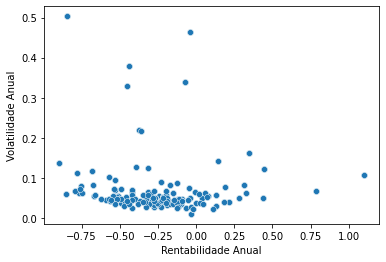

In [12]:
# visualizando os dados
sns.scatterplot(data_model['RENT_A'], data_model['VOLAT_A'])
plt.xlabel('Rentabilidade Anual')
plt.ylabel('Volatilidade Anual')
plt.show()

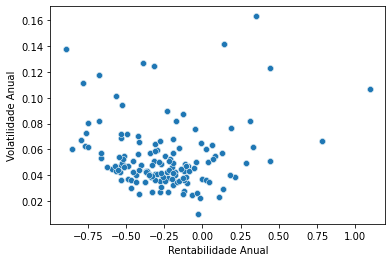

In [13]:
# removendo outliers. Coloquei 0.07 como o threshold, mas depois podemos testar essa etapa com valores diferentes.
data_model = data_model.drop(data_model[data_model.VOLAT_A > 0.2].index)
# e visualizando novamente
sns.scatterplot(data_model['RENT_A'], data_model['VOLAT_A'])
plt.xlabel('Rentabilidade Anual')
plt.ylabel('Volatilidade Anual')
plt.show()

In [14]:
# esse algoritmo do K-Means não aceita um DataFrame - aqui o tipo do objeto data_model é um dataframe
type(data_model)

pandas.core.frame.DataFrame

In [15]:
# com a propriedade .values o dataframe é convertido em numpy array
type(data_model.values)

numpy.ndarray

# Definição das Funções

In [14]:
def calculate_cost(dataset, centroids, cluster):
    sum = 0
    for i, val in enumerate(dataset):
        print("Return:")
        print(i)
        print(val[0])
        print(val[1])
        sum += np.sqrt((centroids[int(cluster[i]), 0]-val[0])**2+(centroids[int(cluster[i]), 1]-val[1])**2)
    return sum

In [15]:
def kmeans(dataset, k):
    diff = 1
    cluster = np.zeros(dataset.shape[0])
    centroids = pd.DataFrame(dataset).sample(n=k).values
    while diff:
        # for each observation
        for i, row in enumerate(dataset):
            mn_dist = float('inf')
            # dist of the point from all centroids
            for idx, centroid in enumerate(centroids):
                d = np.sqrt((centroid[0]-row[0])**2 + (centroid[1]-row[1])**2)
                # store closest centroid
                if mn_dist > d:
                    mn_dist = d
                    cluster[i] = idx
        new_centroids = pd.DataFrame(dataset).groupby(by=cluster).mean().values
        # if centroids are same then leave
        if np.count_nonzero(centroids-new_centroids) == 0:
            diff = 0
        else:
            centroids = new_centroids
    return centroids, cluster

# Ajustando Escalas para o KMeans

In [16]:
# calculando Rentabilidade com escala ajustada: (Observação - Média) / Desvio Padrão
data_model['RENT_M_AJ'] = (data_model['RENT_M'] - data_model.groupby(['CODNEG','ANO']).RENT_M.transform(np.mean)) / data_model.groupby(['CODNEG','ANO']).RENT_M.transform(np.std)
data_model['RENT_A_AJ'] = (data_model['RENT_A'] - data_model.groupby(['ANO']).RENT_A.transform(np.mean)) / data_model.groupby(['ANO']).RENT_A.transform(np.std)
# calculando Volatilidade com escala ajustada: (Observação - Média) / Desvio Padrão
data_model['VOLAT_M_AJ'] = (data_model['VOLAT_M'] - data_model.groupby(['CODNEG','ANO']).VOLAT_M.transform(np.mean)) / data_model.groupby(['CODNEG','ANO']).VOLAT_M.transform(np.std)
data_model['VOLAT_A_AJ'] = (data_model['VOLAT_A'] - data_model.groupby(['ANO']).VOLAT_A.transform(np.mean)) / data_model.groupby(['ANO']).VOLAT_A.transform(np.std)
data_model.describe() # Valores Maximos e Mínimos devem variar entre 3 à -3.
#O peso de ambas variáveis dentro do KMeans agora é o mesmo. 

CODBDI       RENT_M       RENT_A      VOLAT_M      VOLAT_A  \
count  1638.000000  1638.000000  1638.000000  1638.000000  1638.000000   
mean      2.161172    -0.024410    -0.257936     0.045623     0.054194   
std       0.970377     0.122259     0.300974     0.040349     0.025003   
min       2.000000    -0.853700    -0.895510     0.000000     0.010188   
25%       2.000000    -0.076298    -0.457901     0.022343     0.038974   
50%       2.000000    -0.008156    -0.275189     0.033413     0.047312   
75%       2.000000     0.013222    -0.116553     0.054082     0.062187   
max       8.000000     1.153527     1.096975     0.383783     0.162931   

           VOLTOT_A    RENT_M_AJ     RENT_A_AJ    VOLAT_M_AJ    VOLAT_A_AJ  
count  1.638000e+03  1638.000000  1.638000e+03  1.638000e+03  1.638000e+03  
mean   4.083195e+10     0.000000  2.385827e-17  3.470294e-17  1.225448e-16  
std    7.767972e+10     0.955644  1.000000e+00  9.556443e-01  1.000000e+00  
min    4.538987e+09    -2.948979 -2.118369e+00 -1.829064e+00 -1.760021e+00  
25%    8.894589e+09    -0.599274 -6.643922e-01 -6.380142e-01 -6.087361e-01  
50%    1.709948e+10     0.063008 -5.732117e-02 -3.847448e-01 -2.752589e-01  
75%    3.891417e+10     0.542477  4.697547e-01  4.211507e-01  3.196719e-01  
max    6.386395e+11     3.042602  4.501759e+00  3.083043e+00  4.348920e+00

In [18]:
# remove todos NaN
data_model = data_model.fillna(0)
# reorganiza o data model
data_model = data_model.sort_values(['MES','ANO','CODNEG'], ascending=[True,True,True])
# redefine o index
data_model = data_model.reset_index(drop=True)

# WCSS

In [17]:
cost_list = []
for k in range(1, 10):
    print(k)
    centroids, cluster = kmeans(data_model[['RENT_M','VOLAT_M']].values, k)
    # WCSS (Within cluster sum of square)
    cost = calculate_cost(data_model[['RENT_M','VOLAT_M']].values, centroids, cluster)
    cost_list.append(cost)

1
Return:
0
-0.04306523115896155
0.04751856315421814
Return:
1
0.1395572666025029
0.15727144979179666
Return:
2
0.029964043148221542
0.04091287863635395
Return:
3
-0.08804883775534178
0.04012853482386577
Return:
4
-0.06311503223617243
0.027556881846229325
Return:
5
-0.08746355685131157
0.03802012426958123
Return:
6
-0.04866088268577873
0.019911914344968865
Return:
7
0.03505426811381618
0.08415759986418057
Return:
8
0.008499999999999952
0.049238978358823654
Return:
9
-0.13688503696150867
0.11487374211691417
Return:
10
-0.11673469387755098
0.07670855427748366
Return:
11
-0.10134398837631675
0.0666399521841373
Return:
12
-0.0664866689166389
0.03419458277511698
Return:
13
-0.09286412512219
0.046363150723604696
Return:
14
-0.1320072332730562
0.0648825086936305
Return:
15
-0.02895553257497363
0.03718488986357363
Return:
16
-0.033549783549783996
0.07382145777465389
Return:
17
0.043049327354260036
0.04659647251381633
Return:
18
-0.04414414414414425
0.04975825828676205
Return:
19
-0.04785643070

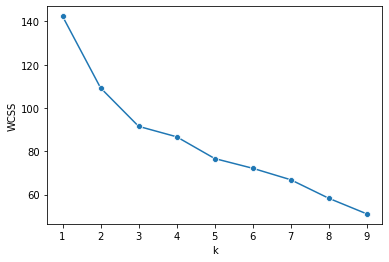

In [21]:
sns.lineplot(x=range(1,10), y=cost_list, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

# K Means Plot

In [22]:
k = 3
centroids, cluster = kmeans(data_model[['RENT_M','VOLAT_M']].values, k)
data_model['CLUSTER'] = cluster

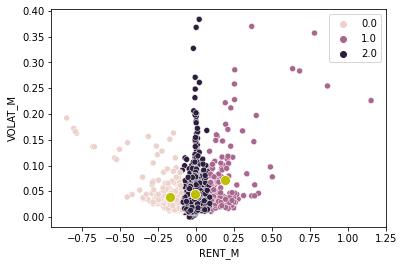

In [23]:
sns.scatterplot(data_model['RENT_M'], data_model['VOLAT_M'], hue=data_model['CLUSTER'])
sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
plt.xlabel('RENT_M')
plt.ylabel('VOLAT_M')
plt.show()

# Verificando Clusters

In [24]:
# Calculando Volatilidade média do cluster por mês e ano
data_model['VOLAT_M_C'] = data_model.groupby(['ANO','MES','CLUSTER']).VOLAT_M.transform(np.mean)
data_model['VOLAT_A_C'] = data_model.groupby(['ANO','CLUSTER']).VOLAT_M.transform(np.mean)

# Calculando Rentabilidade média do cluster por mês
data_model['RENT_M_C'] = data_model.groupby(['ANO','MES','CLUSTER']).RENT_M.transform(np.mean)
data_model['RENT_A_C'] = data_model.groupby(['ANO','CLUSTER']).RENT_M.transform(np.mean)
data_model.head()

CODNEG  CODBDI   ANO MES    RENT_M    RENT_A   VOLAT_M   VOLAT_A  \
0  ABEV3     2.0  2021  01 -0.043065 -0.227512  0.047519  0.037898   
1  AERI3     2.0  2021  01  0.139557 -0.313474  0.157271  0.064097   
2  AGRO3     2.0  2021  01  0.029964  0.080876  0.040913  0.054752   
3  ALPA4     2.0  2021  01 -0.088049 -0.265387  0.040129  0.039675   
4  ALSO3     2.0  2021  01 -0.063115 -0.285667  0.027557  0.049923   

       VOLTOT_A  RENT_M_AJ  RENT_A_AJ  VOLAT_M_AJ  VOLAT_A_AJ  CLUSTER  \
0  9.843127e+10  -0.369803   0.101085    0.681039   -0.651756      2.0   
1  9.127255e+09   1.966513  -0.184528    2.515331    0.396058      1.0   
2  5.516103e+09   0.096369   1.125722   -0.055571    0.022301      2.0   
3  2.299852e+10  -0.649010  -0.024755    0.222473   -0.580675      2.0   
4  9.218449e+09  -0.432816  -0.092136   -0.407275   -0.170808      2.0   

   VOLAT_M_C  VOLAT_A_C  RENT_M_C  RENT_A_C  
0   0.066389   0.043985 -0.006844 -0.008567  
1   0.238417   0.071069  0.319624  0.189167  
2   0.066389   0.043985 -0.006844 -0.008567  
3   0.066389   0.043985 -0.006844 -0.008567  
4   0.066389   0.043985 -0.006844 -0.008567

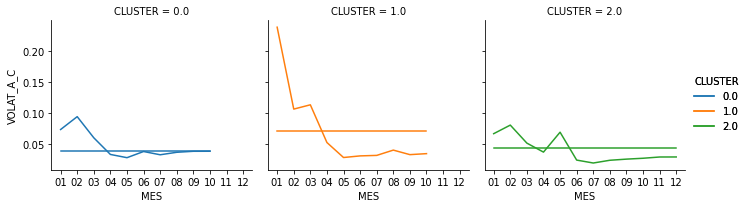

In [25]:
plot1 = sns.FacetGrid(data_model, col='CLUSTER', hue='CLUSTER')
plot1 = plot1.map(sns.lineplot, 'MES', 'VOLAT_M_C', ci=None).add_legend()
plot1 = plot1.map(sns.lineplot, 'MES', 'VOLAT_A_C', ci=None).add_legend()

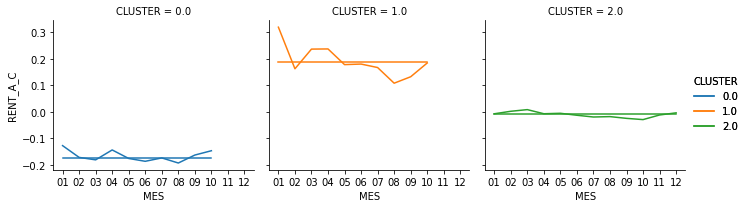

In [26]:
plot1 = sns.FacetGrid(data_model, col='CLUSTER', hue='CLUSTER')
plot1 = plot1.map(sns.lineplot, 'MES', 'RENT_M_C', ci=None).add_legend()
plot1 = plot1.map(sns.lineplot, 'MES', 'RENT_A_C', ci=None).add_legend()

# WCSS 2

In [27]:
cost_list = []
for k in range(1, 10):
    print(k)
    centroids, cluster = kmeans(data_model[['RENT_M_AJ','VOLAT_M_AJ']].values, k)
    # WCSS (Within cluster sum of square)
    cost = calculate_cost(data_model[['RENT_M_AJ','VOLAT_M_AJ']].values, centroids, cluster)
    cost_list.append(cost)

1
Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464


-0.8921885739703609
-0.8402354580310273
Return:
827
-0.9113023775448835
-0.9504185733256965
Return:
828
-0.5355892259034806
-0.7705123021965479
Return:
829
0.37916094350449114
-0.6930167426444028
Return:
830
0.6762521195572405
-0.8033062957537493
Return:
831
-0.29939420378522613
-0.6999601469112494
Return:
832
0.06162620254915207
-0.6868122785971885
Return:
833
0.22249579262563648
-0.9855094678613623
Return:
834
0.9823130033313922
-0.768355209674827
Return:
835
-0.08148201085517459
-0.9536770910728567
Return:
836
-1.0694838755890281
-1.581828483895067
Return:
837
-0.2201595733628494
-1.1615370878439661
Return:
838
-0.1707761823701359
-0.6639549566911123
Return:
839
0.2565054032293893
-0.9995962018411048
Return:
840
-1.7644184736147854
-1.1060091010902724
Return:
841
-0.8652125580605455
-0.6178442983262112
Return:
842
-0.9750212836972943
-0.8339322393273716
Return:
843
-1.2630814798398382
-0.9027300012951935
Return:
844
0.7737195034861177
-0.6695835432526703
Return:
845
-1.2850747453231

1576
1.120809515429575
0.4108930692741155
Return:
1577
-1.3340567120864915
-0.6477578378690088
Return:
1578
0.12300399693510582
-0.2735449948069944
Return:
1579
-1.2281213389580963
-0.8600032340502904
Return:
1580
-0.011776481060821456
0.2674168338469934
Return:
1581
0.6490447677259331
-0.26926852027321635
Return:
1582
-0.6990705867207878
-0.6385796661275827
Return:
1583
-1.0471024315030402
-0.1460022671843159
Return:
1584
1.3180863426046874
-0.2906964982369161
Return:
1585
-0.6289731456766299
-0.5020074820637953
Return:
1586
0.896232411109316
-0.6624035023847397
Return:
1587
-1.130098980500886
-0.48630160651242754
Return:
1588
-0.042966023286244354
-0.46392650972700594
Return:
1589
-0.002031340211920725
-0.59323358586352
Return:
1590
-0.876888988282825
-0.4641699464467369
Return:
1591
0.8465718320396183
-0.0025462908391628175
Return:
1592
-0.2006635465479984
-0.6210588470028463
Return:
1593
0.04730200180820615
-0.7141132570338952
Return:
1594
-1.1066913950859174
-0.7364715935074624
Re

Return:
313
0.12514938936095202
-0.2996227469138845
Return:
314
0.3973694238189165
-0.28754050641428613
Return:
315
0.9241086575342894
0.9644795334257519
Return:
316
0.8172174464372515
0.16495745914104043
Return:
317
0.6058290511835
0.9785984277306315
Return:
318
0.058833779000322044
-0.24467881444159414
Return:
319
0.8763859343756504
-0.010134362972326437
Return:
320
-0.011829233352460748
1.955401581646152
Return:
321
1.806906078172327
1.3806083299374026
Return:
322
-0.13564379076706257
-0.1550408746214429
Return:
323
-0.026380860099786005
1.0125606829013645
Return:
324
0.024960377340116514
-0.3049353706854201
Return:
325
-0.031400047309602525
0.9178834155971848
Return:
326
2.1307875309336657
2.6014338704684556
Return:
327
1.55739598883349
2.053330132936045
Return:
328
1.912182558663175
-0.10115925952790916
Return:
329
2.0307850414701574
0.15785823175164881
Return:
330
1.5933727084524782
0.42146647641853746
Return:
331
1.9796534018980871
0.6627207663456324
Return:
332
0.41107162388816

-0.49498363675598966
Return:
1188
-0.5233101119644746
-0.7442165179395684
Return:
1189
-1.5167667047944076
-0.786697634439828
Return:
1190
-0.23635500918996363
-0.5758551968886949
Return:
1191
-1.2929220002388249
-0.653688137181091
Return:
1192
-1.3091494365642355
-0.6363873981691653
Return:
1193
0.14453377584024565
0.3625006633613874
Return:
1194
0.4029195030932748
-0.4289302795032467
Return:
1195
0.3059623286682965
-0.7701257536382464
Return:
1196
-0.2965252627195317
-0.448931834829661
Return:
1197
-0.8695574325234015
-0.5461009942877614
Return:
1198
0.8790827239758218
-0.5968121451346897
Return:
1199
-0.7469774899755572
-0.6182197497071813
Return:
1200
-1.2479948061794548
-0.0558909561224195
Return:
1201
0.6434638087447087
-0.5320465970491199
Return:
1202
-1.0346067705921527
-0.4465345121089959
Return:
1203
-0.07409530395204178
-0.6389286003470795
Return:
1204
0.7882723106561251
-0.5167545663338016
Return:
1205
0.5511517267235408
-0.9988115647815099
Return:
1206
1.460714398350609
-0

Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464
Re

924
1.1416815947617582
-0.8497869894188012
Return:
925
-1.3145874367157222
-0.6538365635427047
Return:
926
0.6598622796491462
-0.2573479785445442
Return:
927
-1.7525470332142643
-0.8081012693115671
Return:
928
1.2164072093640759
-0.585174037696612
Return:
929
1.9907501533947327
-0.34041981039203234
Return:
930
0.21986425364884693
-0.7601791645825353
Return:
931
-1.2391151348215985
-0.7353201696966595
Return:
932
0.8214945245119116
-0.6353138953904174
Return:
933
-1.2689357298466248
-1.1976232696502593
Return:
934
-0.2990109044958256
-0.6370523908850523
Return:
935
-0.6611174317952856
-0.766184843268966
Return:
936
-0.790601562207088
-0.5912364475152783
Return:
937
-1.364729527044009
-0.9225091056762629
Return:
938
-0.17382662156596357
-0.7581332082083355
Return:
939
0.04815800408950101
-1.046858710126126
Return:
940
1.1198270737844986
-0.7735966356025687
Return:
941
-0.06676799473239799
-1.0246428718120033
Return:
942
-0.9131366023405221
-0.3582517183622254
Return:
943
-0.4611167801468

Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464
Re

-0.8156851288630841
Return:
911
-1.1750015443073138
-0.6270565699065583
Return:
912
-0.794754444257743
-1.2560738136727028
Return:
913
0.3281774227192728
-0.6883391385161796
Return:
914
1.1600294067399772
-0.650599452192879
Return:
915
0.1573423568788077
-0.8930275858490322
Return:
916
0.44391336863167136
-0.8214072863380701
Return:
917
-0.14212685142300943
-0.4739819267041201
Return:
918
-0.20452899606238897
-0.5708506617520276
Return:
919
-1.0700083719445004
-1.2083097357013524
Return:
920
-0.9827240080807184
-0.7972900414591344
Return:
921
-0.2550644777770208
-0.7094028607778345
Return:
922
-0.53456032709679
-0.5793742247936259
Return:
923
-0.9041982919106056
-0.7551906435125055
Return:
924
1.1416815947617582
-0.8497869894188012
Return:
925
-1.3145874367157222
-0.6538365635427047
Return:
926
0.6598622796491462
-0.2573479785445442
Return:
927
-1.7525470332142643
-0.8081012693115671
Return:
928
1.2164072093640759
-0.585174037696612
Return:
929
1.9907501533947327
-0.34041981039203234
R

Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464
Re

897
0.026511615209221795
-0.5974875765959826
Return:
898
-1.2324849622307217
-0.6400869834409539
Return:
899
0.1508366695114223
-0.8545627631899583
Return:
900
1.5237749095328421
-0.33947154421271963
Return:
901
0.0742142692483166
-0.9621831614928601
Return:
902
-1.8876850595806742
-0.5952463375859065
Return:
903
-0.31705919097129753
-0.9969503359155687
Return:
904
-1.449819620062894
-0.5783926719832538
Return:
905
-2.415945697235673
-0.6721321721469589
Return:
906
-2.2003592164952095
-0.6709372759962109
Return:
907
-0.879401154620187
-0.8946963538298017
Return:
908
-1.3122084262054736
-0.914992048637264
Return:
909
0.004570627638263604
-0.5411121574060899
Return:
910
0.03803274250559254
-0.8156851288630841
Return:
911
-1.1750015443073138
-0.6270565699065583
Return:
912
-0.794754444257743
-1.2560738136727028
Return:
913
0.3281774227192728
-0.6883391385161796
Return:
914
1.1600294067399772
-0.650599452192879
Return:
915
0.1573423568788077
-0.8930275858490322
Return:
916
0.44391336863167

Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464
Re

1.3589214245109342
Return:
884
-2.8475381809313283
2.7980809735423997
Return:
885
0.1365194528860356
-0.7908794695776685
Return:
886
-0.5617961397162239
-0.8953378378554132
Return:
887
-0.22201603860693708
-0.8448652087450198
Return:
888
0.13574362069765875
-0.8300897164766928
Return:
889
-0.3022741972216828
-1.0310836874691414
Return:
890
-0.21664907430826613
-0.8127550655835276
Return:
891
-0.5036003663060319
-0.8132989999374349
Return:
892
0.6657180011356043
-0.7533261020734984
Return:
893
-2.4527767425601374
-0.7956748392528905
Return:
894
1.6138221616018968
-0.45663872057332777
Return:
895
-0.11521543397335109
-0.9437397189213815
Return:
896
-1.0478138292743697
-0.9324544951415829
Return:
897
0.026511615209221795
-0.5974875765959826
Return:
898
-1.2324849622307217
-0.6400869834409539
Return:
899
0.1508366695114223
-0.8545627631899583
Return:
900
1.5237749095328421
-0.33947154421271963
Return:
901
0.0742142692483166
-0.9621831614928601
Return:
902
-1.8876850595806742
-0.59524633758

Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464
Re

0.784501597215047
-0.5219815511450118
Return:
996
0.4180384846465147
-0.637571639358101
Return:
997
-0.9274528506173797
-0.4668371328403054
Return:
998
0.19198793930734767
-0.45180678057537416
Return:
999
0.16046886223847573
-0.6964297623652936
Return:
1000
1.1884842174649148
-0.6097612957664558
Return:
1001
0.8907912983286113
-0.7398770225427399
Return:
1002
-1.3555637107382943
-0.48383347453383413
Return:
1003
-1.4111896994316246
-0.8186336946783224
Return:
1004
0.12218324758827585
-0.39661928462439827
Return:
1005
0.2711557849500412
-0.3923808317560132
Return:
1006
0.23928105183573917
-0.5298512001216175
Return:
1007
-0.017200128854905017
-0.5588513430956772
Return:
1008
-0.39072718784711863
-0.6034002071961243
Return:
1009
1.3114282053440474
-0.565389554512396
Return:
1010
-1.2056718848774781
-0.3727990498775006
Return:
1011
-0.4944752334626741
-0.5799238765521599
Return:
1012
-0.09389870620119027
-0.870283354560879
Return:
1013
-1.7452628959669287
-0.6914150399915824
Return:
1014


Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464
Re

-0.9870231968643092
Return:
857
-0.2659808196756878
-0.6326110158848012
Return:
858
0.12226423980282176
-1.198636388907655
Return:
859
-0.342920376040841
-0.704504045956975
Return:
860
-0.7199811187797199
-0.9420855306031855
Return:
861
0.9851092288487123
-0.9468503100407559
Return:
862
-0.4735864610482551
-0.8753797519746684
Return:
863
-1.1350051102672536
-1.010302671828795
Return:
864
-1.0568983465520017
-0.933249124237837
Return:
865
1.003518766694185
-0.8368085933605075
Return:
866
-1.1467259001121977
-1.1319318941899172
Return:
867
-0.5065828988056464
-0.6014584031158112
Return:
868
0.6309783282414193
-0.8909672913479907
Return:
869
-0.7348864161909066
-0.9329258018801302
Return:
870
1.543683534620638
-1.0933450359628527
Return:
871
-0.6543530296483767
-0.7123142249177209
Return:
872
-0.7087319445861733
-1.1601122504053307
Return:
873
-0.0599038036176543
-0.5826174278771893
Return:
874
1.2701038391027435
-0.4344889851675652
Return:
875
0.19397241558730527
-0.712876923711784
Retur

Return:
0
-0.3698032560636041
0.6810386408342405
Return:
1
1.966512611208356
2.5153313772799444
Return:
2
0.09636912944386188
-0.05557060945614184
Return:
3
-0.6490103820939147
0.22247306752048032
Return:
4
-0.4328155712346315
-0.40727538920087014
Return:
5
-0.27204276427520974
-0.710094260082515
Return:
6
-0.45360464529582806
-1.4429053384230124
Return:
7
0.6740282707250035
1.9881636204603899
Return:
8
0.685051587284526
0.25316259586331114
Return:
9
-1.6732652361436433
1.9671893131607463
Return:
10
-1.2596119641899868
1.8050740848586815
Return:
11
-0.986328293047746
1.2127172191920224
Return:
12
-0.6763106021269321
0.6442300430673344
Return:
13
-0.6654877135087821
1.1370089381992219
Return:
14
-0.9196699670419796
1.6492767975197666
Return:
15
0.15873113967644825
-0.7538437166754631
Return:
16
0.25517010718939487
0.8909208406238307
Return:
17
0.7554277106984136
0.24981100691960587
Return:
18
-0.18974445857798347
0.14974582848399276
Return:
19
-0.2891518044036435
-0.32179240938722464
Re

843
-1.2630814798398382
-0.9027300012951935
Return:
844
0.7737195034861177
-0.6695835432526703
Return:
845
-1.2850747453231486
-0.9071299718150856
Return:
846
-1.2688141473891934
-0.25709458731945195
Return:
847
-0.5297268342582565
-1.2115709347929002
Return:
848
-0.8326080922825794
-1.3230604986279937
Return:
849
-1.3844988107567961
-0.9216344099761062
Return:
850
-0.39066946094986965
-0.8098199419896455
Return:
851
-1.02556633100973
-0.7635721785142192
Return:
852
-0.4675401926483074
-0.8196007484927846
Return:
853
-0.4258756097873011
-0.6398242278475728
Return:
854
-1.7356698142883586
-0.6041585181161395
Return:
855
-0.9247236379219522
-0.9415707312392888
Return:
856
-0.8678888982004284
-0.9870231968643092
Return:
857
-0.2659808196756878
-0.6326110158848012
Return:
858
0.12226423980282176
-1.198636388907655
Return:
859
-0.342920376040841
-0.704504045956975
Return:
860
-0.7199811187797199
-0.9420855306031855
Return:
861
0.9851092288487123
-0.9468503100407559
Return:
862
-0.4735864610

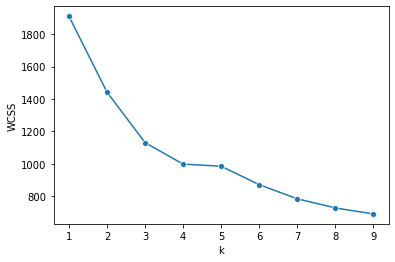

In [28]:
sns.lineplot(x=range(1,10), y=cost_list, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

# K Means Plot 2

In [30]:
k = 4
centroids, cluster = kmeans(data_model[['RENT_M_AJ','VOLAT_M_AJ']].values, k)
data_model['CLUSTER2'] = cluster

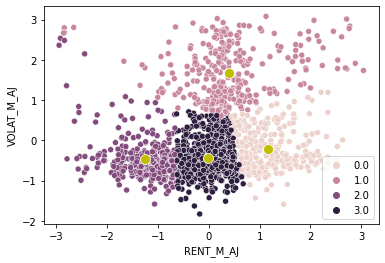

In [31]:
sns.scatterplot(data_model['RENT_M_AJ'], data_model['VOLAT_M_AJ'], hue=data_model['CLUSTER2'])
sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
plt.xlabel('RENT_M_AJ')
plt.ylabel('VOLAT_M_AJ')
plt.show()

# Verificando Clusters 2

In [32]:
# Calculando Volatilidade média do cluster por mês e ano
data_model['VOLAT_M_C2'] = data_model.groupby(['ANO','MES','CLUSTER2']).VOLAT_M.transform(np.mean)
data_model['VOLAT_A_C2'] = data_model.groupby(['ANO','CLUSTER2']).VOLAT_M.transform(np.mean)

# Calculando Rentabilidade média do cluster por mês
data_model['RENT_M_C2'] = data_model.groupby(['ANO','MES','CLUSTER2']).RENT_M.transform(np.mean)
data_model['RENT_A_C2'] = data_model.groupby(['ANO','CLUSTER2']).RENT_M.transform(np.mean)
data_model.head()

CODNEG  CODBDI   ANO MES    RENT_M    RENT_A   VOLAT_M   VOLAT_A  \
0  ABEV3     2.0  2021  01 -0.043065 -0.227512  0.047519  0.037898   
1  AERI3     2.0  2021  01  0.139557 -0.313474  0.157271  0.064097   
2  AGRO3     2.0  2021  01  0.029964  0.080876  0.040913  0.054752   
3  ALPA4     2.0  2021  01 -0.088049 -0.265387  0.040129  0.039675   
4  ALSO3     2.0  2021  01 -0.063115 -0.285667  0.027557  0.049923   

       VOLTOT_A  RENT_M_AJ  ...  CLUSTER  VOLAT_M_C  VOLAT_A_C  RENT_M_C  \
0  9.843127e+10  -0.369803  ...      2.0   0.066389   0.043985 -0.006844   
1  9.127255e+09   1.966513  ...      1.0   0.238417   0.071069  0.319624   
2  5.516103e+09   0.096369  ...      2.0   0.066389   0.043985 -0.006844   
3  2.299852e+10  -0.649010  ...      2.0   0.066389   0.043985 -0.006844   
4  9.218449e+09  -0.432816  ...      2.0   0.066389   0.043985 -0.006844   

   RENT_A_C  CLUSTER2  VOLAT_M_C2  VOLAT_A_C2  RENT_M_C2  RENT_A_C2  
0 -0.008567       3.0    0.044471    0.033007  -0.014229  -0.024915  
1  0.189167       1.0    0.102445    0.096387   0.008902   0.016525  
2 -0.008567       3.0    0.044471    0.033007  -0.014229  -0.024915  
3 -0.008567       3.0    0.044471    0.033007  -0.014229  -0.024915  
4 -0.008567       3.0    0.044471    0.033007  -0.014229  -0.024915  

[5 rows x 23 columns]

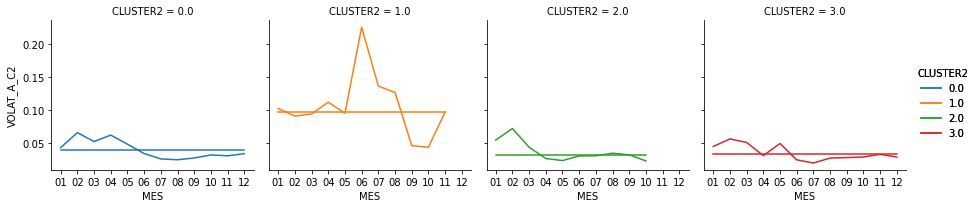

In [33]:
plot2 = sns.FacetGrid(data_model, col='CLUSTER2', hue='CLUSTER2')
plot2 = plot2.map(sns.lineplot, 'MES', 'VOLAT_M_C2', ci=None).add_legend()
plot2 = plot2.map(sns.lineplot, 'MES', 'VOLAT_A_C2', ci=None).add_legend()

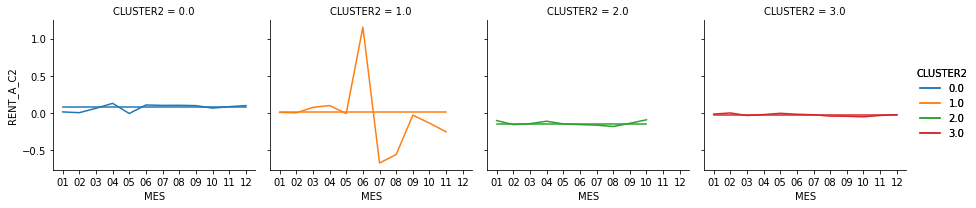

In [34]:
plot2 = sns.FacetGrid(data_model, col='CLUSTER2', hue='CLUSTER2')
plot2 = plot2.map(sns.lineplot, 'MES', 'RENT_M_C2', ci=None).add_legend()
plot2 = plot2.map(sns.lineplot, 'MES', 'RENT_A_C2', ci=None).add_legend()

# WCSS 3

In [35]:
cost_list = []
for k in range(1, 10):
    print(k)
    centroids, cluster = kmeans(data_model[['RENT_A_AJ','VOLAT_A_AJ']].values, k)
    # WCSS (Within cluster sum of square)
    cost = calculate_cost(data_model[['RENT_A_AJ','VOLAT_A_AJ']].values, centroids, cluster)
    cost_list.append(cost)

1
Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.034904250397532

0.5889082677691447
Return:
816
1.7970870191387136
-0.17837671487983195
Return:
817
-1.0461540203593487
-0.41726166990023944
Return:
818
0.26000622442488486
-0.4645969220167164
Return:
819
-1.9784198944929827
0.2616256528743214
Return:
820
-0.9110948189020309
-0.24321793318939963
Return:
821
-0.18998880663253126
-0.1353542729061551
Return:
822
-0.29696739919637705
-0.5367217188219535
Return:
823
-0.36866742125554786
-0.43753251160441103
Return:
824
-0.05799228402832855
-1.0821863421802502
Return:
825
0.24193041569726495
-0.7972351639325258
Return:
826
-0.9447637126254835
-0.47559143368100015
Return:
827
-0.785504152435338
0.7006106412183669
Return:
828
-1.0312054497387455
1.8920432794448079
Return:
829
-1.356281425889341
-0.018753185736964825
Return:
830
0.5455434808376622
-0.28344580065432246
Return:
831
-0.12256996827489748
0.2263625359502986
Return:
832
-0.03490425039753215
-0.21070942035534718
Return:
833
0.4349123872682839
1.3304242768633943
Return:
834
-2.118368658891557
3.3515707

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

Return:
905
1.0588557780507806
0.3646774225759093
Return:
906
0.9235538686153576
0.25171580926803266
Return:
907
-0.1794156668451016
0.17048311129384658
Return:
908
1.0844327229514266
-0.05739312358389679
Return:
909
1.3322483351007717
3.488234647738957
Return:
910
-1.036882632187377
-0.28822128945262127
Return:
911
0.2850028731897894
1.1188665645746574
Return:
912
-0.6893058289199648
-0.7072900182395564
Return:
913
0.9402692607311965
-0.7097260610416128
Return:
914
0.4327748826521219
-0.6509698647011833
Return:
915
0.12627616808176959
-0.40677358312120854
Return:
916
-0.3983256952831642
-0.771253692345003
Return:
917
0.22543908078257222
-0.4904805225291827
Return:
918
-0.1927488629321438
2.7975550065068884
Return:
919
0.35160685951826876
0.2780739455630486
Return:
920
0.9990825379413356
-0.77015816837064
Return:
921
-0.5317413921517784
-0.39945291354622714
Return:
922
1.4558159040137266
-0.5585944849392566
Return:
923
-0.9256961833033408
0.7086278872588029
Return:
924
-1.7751078038800

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

-0.1269250674104068
Return:
789
0.5584402644755446
-0.4432445160020852
Return:
790
-0.05732117100818862
0.5059152052812903
Return:
791
-0.24631227984328524
-0.5933319688296768
Return:
792
0.20641726687714473
0.5634365888574777
Return:
793
0.6837027218929674
-0.35134612932117426
Return:
794
1.9462664112735188
0.31967187007155207
Return:
795
-0.30581499924446565
-0.5638534484074187
Return:
796
0.7392841234679949
-1.1159645007816634
Return:
797
0.3820180779226087
-0.3718107631102528
Return:
798
0.44266049708597205
-1.1438556012626295
Return:
799
-0.05274412997291241
-0.4809747974643873
Return:
800
-0.08458658620457968
-0.14640494001700935
Return:
801
-0.592250285360761
-0.7632520637122012
Return:
802
-1.6782862930247855
0.7393719751501269
Return:
803
0.2002510493304885
-0.6938515672037537
Return:
804
-0.4413706325363032
2.9122918097521455
Return:
805
1.215717014521558
-1.224422883472948
Return:
806
0.05186713863199196
0.041295112126755046
Return:
807
-1.2189659600332163
-0.313282876430553

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

900
-1.3997521524492622
2.5216954844173407
Return:
901
-0.9061547768391798
-0.7249950341278051
Return:
902
-1.3503219851857216
0.11736279831833392
Return:
903
-0.23258405804807353
-1.080647695252015
Return:
904
0.09013583002657528
1.4184401233087758
Return:
905
1.0588557780507806
0.3646774225759093
Return:
906
0.9235538686153576
0.25171580926803266
Return:
907
-0.1794156668451016
0.17048311129384658
Return:
908
1.0844327229514266
-0.05739312358389679
Return:
909
1.3322483351007717
3.488234647738957
Return:
910
-1.036882632187377
-0.28822128945262127
Return:
911
0.2850028731897894
1.1188665645746574
Return:
912
-0.6893058289199648
-0.7072900182395564
Return:
913
0.9402692607311965
-0.7097260610416128
Return:
914
0.4327748826521219
-0.6509698647011833
Return:
915
0.12627616808176959
-0.40677358312120854
Return:
916
-0.3983256952831642
-0.771253692345003
Return:
917
0.22543908078257222
-0.4904805225291827
Return:
918
-0.1927488629321438
2.7975550065068884
Return:
919
0.35160685951826876
0

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

0.9008635300835911
Return:
887
-0.2903197943988935
0.11385911048283477
Return:
888
-0.8551534970393843
-0.31295987288707205
Return:
889
-0.5782682347432196
-0.5467762586510377
Return:
890
-0.9017007262426605
1.618356561791409
Return:
891
0.2936644278687096
-0.7876356937340722
Return:
892
-1.6237652564769223
0.3208890716996892
Return:
893
-1.383451154290554
1.126385784487831
Return:
894
-0.16714345609420625
-0.7232325060338474
Return:
895
2.3208385789228143
-0.12458207277868849
Return:
896
-0.36960178437937824
-0.45542513921891786
Return:
897
0.49321551411435477
-0.2715854575049361
Return:
898
0.823153204033933
0.416384653119412
Return:
899
0.3567101898846811
-0.7441611941122035
Return:
900
-1.3997521524492622
2.5216954844173407
Return:
901
-0.9061547768391798
-0.7249950341278051
Return:
902
-1.3503219851857216
0.11736279831833392
Return:
903
-0.23258405804807353
-1.080647695252015
Return:
904
0.09013583002657528
1.4184401233087758
Return:
905
1.0588557780507806
0.3646774225759093
Retur

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

998
-0.8353312150999331
-0.2789252469343707
Return:
999
3.4657640031028953
0.5066661279750099
Return:
1000
2.0155401745399186
4.348919644276914
Return:
1001
-0.52819611766213
-1.1538619480340169
Return:
1002
-0.9572969234294953
-0.01420427261963156
Return:
1003
0.14437949096823519
-0.059356340105880374
Return:
1004
-0.05266501569159056
-0.9178182206821276
Return:
1005
0.20723903320814302
0.12188344175443695
Return:
1006
0.226103102479123
-0.1985513898163402
Return:
1007
-0.6643922422397704
-0.12102931838320716
Return:
1008
0.49789311296218064
-0.6281980285486911
Return:
1009
-0.4797961538555602
-0.23752604426021975
Return:
1010
-0.7660396376886965
-0.27525887442213764
Return:
1011
4.5017588213411255
2.1023296265251847
Return:
1012
0.09810391977051586
-1.0754198136134234
Return:
1013
0.4697546555754108
-0.22744600007461127
Return:
1014
0.9869644795346117
-0.147076621339983
Return:
1015
-0.3401726016975603
-0.4320784164849087
Return:
1016
0.21759872884988435
-0.8606591227051485
Return:
1

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

-0.4426527627993826
Return:
985
0.45739489530973126
-0.4220692943753206
Return:
986
1.2821493590164736
0.11909327970643997
Return:
987
0.45086673364110835
-0.7010725720653904
Return:
988
-0.7666272451872962
-0.6951852283691956
Return:
989
0.6317390232489758
-1.178331926787763
Return:
990
-0.5380442782554229
0.08097481196334376
Return:
991
1.8996280087750892
1.1087471118793344
Return:
992
0.18997544836483
-0.32275965977704796
Return:
993
1.2938604610699396
-0.9972898538029887
Return:
994
-1.7307708408508855
2.2795981936120002
Return:
995
0.8553186031711092
-0.6686725081471286
Return:
996
-0.8740232224437006
-0.06542315574290086
Return:
997
2.335041543895412
2.753619934093937
Return:
998
-0.8353312150999331
-0.2789252469343707
Return:
999
3.4657640031028953
0.5066661279750099
Return:
1000
2.0155401745399186
4.348919644276914
Return:
1001
-0.52819611766213
-1.1538619480340169
Return:
1002
-0.9572969234294953
-0.01420427261963156
Return:
1003
0.14437949096823519
-0.059356340105880374
Retur

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

971
-2.118368658891557
3.351570786883886
Return:
972
-0.2730115611678723
-0.6167306894770366
Return:
973
-1.1085934173041312
-0.35789159642360807
Return:
974
-0.8463151910350083
0.025344344280310308
Return:
975
0.719052101982149
-0.15059828762147806
Return:
976
-0.16657815749714094
-0.5271400242648515
Return:
977
-0.8941631047810904
-0.20165108972465307
Return:
978
0.5229233018258861
-0.8099184118973753
Return:
979
-0.13000002274265185
-0.5364124404262841
Return:
980
-0.07708652112407954
-0.7459435118403649
Return:
981
-0.5269440883790971
0.4741596117499061
Return:
982
-0.5353243165588057
0.6417134637236556
Return:
983
-0.23522457117868628
-0.25876916732080807
Return:
984
-1.0223603499946519
-0.4426527627993826
Return:
985
0.45739489530973126
-0.4220692943753206
Return:
986
1.2821493590164736
0.11909327970643997
Return:
987
0.45086673364110835
-0.7010725720653904
Return:
988
-0.7666272451872962
-0.6951852283691956
Return:
989
0.6317390232489758
-1.178331926787763
Return:
990
-0.5380442

Return:
0
0.10108547610871392
-0.6517556928838096
Return:
1
-0.18452773266463668
0.39605779078947817
Return:
2
1.1257215081859833
0.02230133118849056
Return:
3
-0.024754744078433213
-0.5806746769425695
Return:
4
-0.09213558627157917
-0.17080831062642274
Return:
5
-0.9119913795068331
0.5889082677691447
Return:
6
1.7970870191387136
-0.17837671487983195
Return:
7
0.26000622442488486
-0.4645969220167164
Return:
8
-0.9110948189020309
-0.24321793318939963
Return:
9
-0.18998880663253126
-0.1353542729061551
Return:
10
-0.29696739919637705
-0.5367217188219535
Return:
11
-0.36866742125554786
-0.43753251160441103
Return:
12
-0.05799228402832855
-1.0821863421802502
Return:
13
0.24193041569726495
-0.7972351639325258
Return:
14
-0.9447637126254835
-0.47559143368100015
Return:
15
-1.0312054497387455
1.8920432794448079
Return:
16
-1.356281425889341
-0.018753185736964825
Return:
17
0.5455434808376622
-0.28344580065432246
Return:
18
-0.12256996827489748
0.2263625359502986
Return:
19
-0.03490425039753215

-0.21070942035534718
Return:
833
0.4349123872682839
1.3304242768633943
Return:
834
-2.118368658891557
3.351570786883886
Return:
835
-0.2730115611678723
-0.6167306894770366
Return:
836
-1.1085934173041312
-0.35789159642360807
Return:
837
-0.8463151910350083
0.025344344280310308
Return:
838
0.719052101982149
-0.15059828762147806
Return:
839
-0.16657815749714094
-0.5271400242648515
Return:
840
-0.8941631047810904
-0.20165108972465307
Return:
841
0.5229233018258861
-0.8099184118973753
Return:
842
-0.13000002274265185
-0.5364124404262841
Return:
843
-0.07708652112407954
-0.7459435118403649
Return:
844
-0.5269440883790971
0.4741596117499061
Return:
845
-0.5353243165588057
0.6417134637236556
Return:
846
-0.23522457117868628
-0.25876916732080807
Return:
847
-1.0223603499946519
-0.4426527627993826
Return:
848
0.45739489530973126
-0.4220692943753206
Return:
849
1.2821493590164736
0.11909327970643997
Return:
850
-0.7666272451872962
-0.6951852283691956
Return:
851
0.6317390232489758
-1.17833192678

-0.16714345609420625
-0.7232325060338474
Return:
1583
2.3208385789228143
-0.12458207277868849
Return:
1584
-0.36960178437937824
-0.45542513921891786
Return:
1585
0.49321551411435477
-0.2715854575049361
Return:
1586
0.823153204033933
0.416384653119412
Return:
1587
0.3567101898846811
-0.7441611941122035
Return:
1588
-1.3997521524492622
2.5216954844173407
Return:
1589
-0.9061547768391798
-0.7249950341278051
Return:
1590
-1.3503219851857216
0.11736279831833392
Return:
1591
-0.23258405804807353
-1.080647695252015
Return:
1592
0.09013583002657528
1.4184401233087758
Return:
1593
1.0588557780507806
0.3646774225759093
Return:
1594
0.9235538686153576
0.25171580926803266
Return:
1595
-0.1794156668451016
0.17048311129384658
Return:
1596
1.0844327229514266
-0.05739312358389679
Return:
1597
1.3322483351007717
3.488234647738957
Return:
1598
-1.036882632187377
-0.28822128945262127
Return:
1599
0.2850028731897894
1.1188665645746574
Return:
1600
-0.6893058289199648
-0.7072900182395564
Return:
1601
0.940

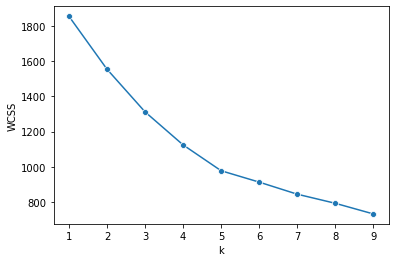

In [36]:
sns.lineplot(x=range(1,10), y=cost_list, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

# KMeans Plot 3

In [46]:
k = 5
centroids, cluster = kmeans(data_model[['RENT_A_AJ','VOLAT_A_AJ']].values, k)
data_model['CLUSTER3'] = cluster
data_model.shape

(1638, 14)

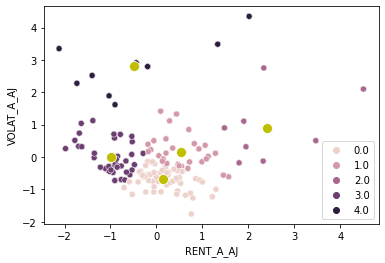

In [19]:
sns.scatterplot(data_model['RENT_A_AJ'], data_model['VOLAT_A_AJ'], hue=data_model['CLUSTER3'])
sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
plt.xlabel('RENT_A_AJ')
plt.ylabel('VOLAT_A_AJ')
plt.show()

# Verificando Cluster 3

In [39]:
# Calculando Volatilidade média do cluster por mês e ano
data_model['VOLAT_M_C3'] = data_model.groupby(['ANO','MES','CLUSTER3']).VOLAT_M.transform(np.mean)
data_model['VOLAT_A_C3'] = data_model.groupby(['ANO','CLUSTER3']).VOLAT_M.transform(np.mean)

# Calculando Rentabilidade média do cluster por mês
data_model['RENT_M_C3'] = data_model.groupby(['ANO','MES','CLUSTER3']).RENT_M.transform(np.mean)
data_model['RENT_A_C3'] = data_model.groupby(['ANO','CLUSTER3']).RENT_M.transform(np.mean)
data_model.head()

CODNEG  CODBDI   ANO MES    RENT_M    RENT_A   VOLAT_M   VOLAT_A  \
0  ABEV3     2.0  2021  01 -0.043065 -0.227512  0.047519  0.037898   
1  AERI3     2.0  2021  01  0.139557 -0.313474  0.157271  0.064097   
2  AGRO3     2.0  2021  01  0.029964  0.080876  0.040913  0.054752   
3  ALPA4     2.0  2021  01 -0.088049 -0.265387  0.040129  0.039675   
4  ALSO3     2.0  2021  01 -0.063115 -0.285667  0.027557  0.049923   

       VOLTOT_A  RENT_M_AJ  ...  CLUSTER2  VOLAT_M_C2  VOLAT_A_C2  RENT_M_C2  \
0  9.843127e+10  -0.369803  ...       3.0    0.044471    0.033007  -0.014229   
1  9.127255e+09   1.966513  ...       1.0    0.102445    0.096387   0.008902   
2  5.516103e+09   0.096369  ...       3.0    0.044471    0.033007  -0.014229   
3  2.299852e+10  -0.649010  ...       3.0    0.044471    0.033007  -0.014229   
4  9.218449e+09  -0.432816  ...       3.0    0.044471    0.033007  -0.014229   

   RENT_A_C2  CLUSTER3  VOLAT_M_C3  VOLAT_A_C3  RENT_M_C3  RENT_A_C3  
0  -0.024915       2.0    0.057835    0.034505  -0.008038  -0.012602  
1   0.016525       0.0    0.070484    0.040383  -0.035006  -0.045008  
2  -0.024915       3.0    0.065850    0.052266   0.014541   0.020711  
3  -0.024915       2.0    0.057835    0.034505  -0.008038  -0.012602  
4  -0.024915       0.0    0.070484    0.040383  -0.035006  -0.045008  

[5 rows x 28 columns]

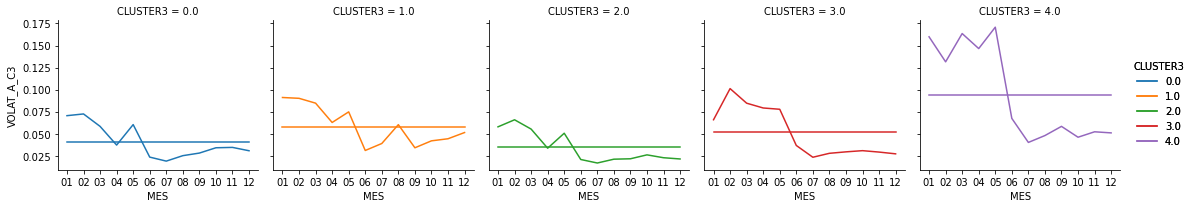

In [40]:
plot3 = sns.FacetGrid(data_model, col='CLUSTER3', hue='CLUSTER3')
plot3 = plot3.map(sns.lineplot, 'MES', 'VOLAT_M_C3', ci=None).add_legend()
plot3 = plot3.map(sns.lineplot, 'MES', 'VOLAT_A_C3', ci=None).add_legend()

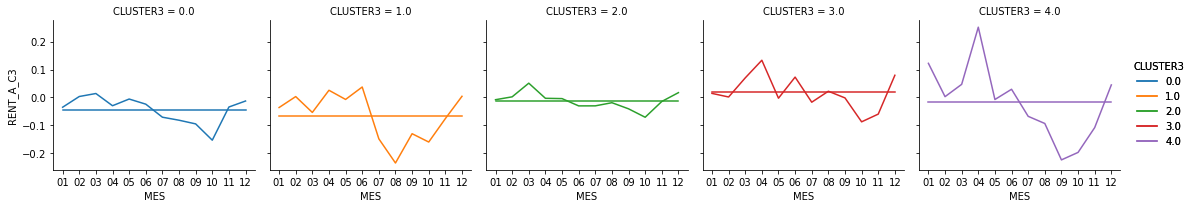

In [41]:
plot3 = sns.FacetGrid(data_model, col='CLUSTER3', hue='CLUSTER3')
plot3 = plot3.map(sns.lineplot, 'MES', 'RENT_M_C3', ci=None).add_legend()
plot3 = plot3.map(sns.lineplot, 'MES', 'RENT_A_C3', ci=None).add_legend()

In [42]:
# Visualizando ações por cluster
data_model.to_csv('data_model_cluster3.csv')

# DBSCAN Sklearn

In [32]:
DBSCAN_cluster = DBSCAN(eps=0.25, min_samples=5).fit(data_model[['RENT_A_AJ','VOLAT_A_AJ']].values) 
print(DBSCAN_cluster.labels_)

[ 0  0  1 ...  0 31  0]


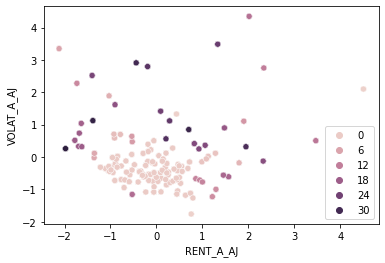

In [33]:
sns.scatterplot(data_model['RENT_A_AJ'], data_model['VOLAT_A_AJ'], hue=DBSCAN_cluster.labels_)
plt.xlabel('RENT_A_AJ')
plt.ylabel('VOLAT_A_AJ')
plt.show()

# Birch SkLearn

In [33]:
data_model_birch = np.ascontiguousarray(data_model[['RENT_A_AJ','VOLAT_A_AJ']].values)
Birch_cluster = Birch(n_clusters=5)
Birch_cluster.fit(data_model_birch)
Birch_cluster.predict(data_model_birch)
Birch_cluster

[4 1 4 1 2 1 2 0 4 3 0 3 0 1 4 0 3 2]


In [40]:
centroid_bir = np.array([(0.039656,-0.54034853),(-0.46363767,0.40882395),(-1.26585729,2.07792338),(1.68897462,1.00480532),(2.33504154,2.75361993)])
print(centroid_bir)

[[ 0.039656   -0.54034853]
 [-0.46363767  0.40882395]
 [-1.26585729  2.07792338]
 [ 1.68897462  1.00480532]
 [ 2.33504154  2.75361993]]


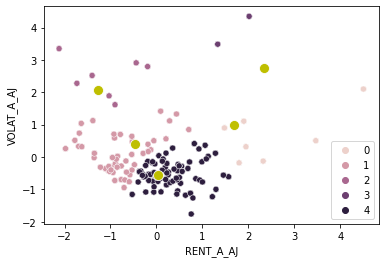

In [41]:
sns.scatterplot(data_model['RENT_A_AJ'], data_model['VOLAT_A_AJ'], hue=Birch_cluster.predict(data_model_birch))
sns.scatterplot(centroid_bir[:,0], centroid_bir[:, 1], s=100, color='y')
plt.xlabel('RENT_A_AJ')
plt.ylabel('VOLAT_A_AJ')
plt.show()

In [62]:
data_model['BIRCH'] = Birch_cluster.labels_
data_model.head()

CODNEG  CODBDI   ANO MES    RENT_M    RENT_A   VOLAT_M   VOLAT_A  \
0  ABEV3     2.0  2021  01 -0.043065 -0.227512  0.047519  0.037898   
1  AERI3     2.0  2021  01  0.139557 -0.313474  0.157271  0.064097   
2  AGRO3     2.0  2021  01  0.029964  0.080876  0.040913  0.054752   
3  ALPA4     2.0  2021  01 -0.088049 -0.265387  0.040129  0.039675   
4  ALSO3     2.0  2021  01 -0.063115 -0.285667  0.027557  0.049923   

       VOLTOT_A  RENT_M_AJ  RENT_A_AJ  VOLAT_M_AJ  VOLAT_A_AJ  CLUSTER3  \
0  9.843127e+10  -0.369803   0.101085    0.681039   -0.651756       0.0   
1  9.127255e+09   1.966513  -0.184528    2.515331    0.396058       1.0   
2  5.516103e+09   0.096369   1.125722   -0.055571    0.022301       2.0   
3  2.299852e+10  -0.649010  -0.024755    0.222473   -0.580675       0.0   
4  9.218449e+09  -0.432816  -0.092136   -0.407275   -0.170808       0.0   

   KMEANSSK  VOLAT_A_KMEANSSK  RENT_A_KMEANSSK  VOLAT_M_KMEANSSK  \
0         3          0.034881        -0.016762          0.059295   
1         1          0.045858        -0.054625          0.074276   
2         0          0.051417         0.017274          0.067005   
3         3          0.034881        -0.016762          0.059295   
4         3          0.034881        -0.016762          0.059295   

   RENT_M_KMEANSSK  BIRCH  
0        -0.016103      4  
1        -0.032899      1  
2         0.014959      4  
3        -0.016103      4  
4        -0.016103      4

In [ ]:

data_model['VOLAT_M_BIRCH'] = data_model.groupby(['ANO','MES','BIRCH']).VOLAT_M.transform(np.mean)
data_model['VOLAT_A_BIRCH'] = data_model.groupby(['ANO','BIRCH']).VOLAT_M.transform(np.mean)

# Calculando Rentabilidade média do cluster por mês
data_model['RENT_M_BIRCH'] = data_model.groupby(['ANO','MES','BIRCH']).RENT_M.transform(np.mean)
data_model['RENT_A_BIRCH'] = data_model.groupby(['ANO','BIRCH']).RENT_M.transform(np.mean)
data_model.head()

# Kmeans SkLearn

In [47]:
Kmeans_cluster = KMeans(n_clusters=5).fit(data_model[['RENT_A_AJ','VOLAT_A_AJ']].values)
centroids_clus = Kmeans_cluster.cluster_centers_
#print(centroids_clus)
Kmeans_cluster.labels_.shape
data_model['KMEANSSK'] = Kmeans_cluster.labels_

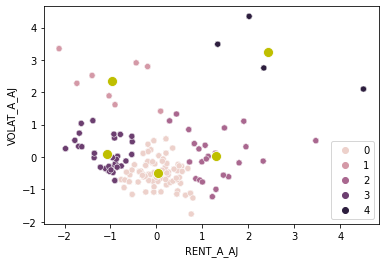

In [29]:
sns.scatterplot(data_model['RENT_A_AJ'], data_model['VOLAT_A_AJ'], hue=Kmeans_cluster.labels_)
sns.scatterplot(centroids_clus[:,0], centroids_clus[:, 1], s=100, color='y')
plt.xlabel('RENT_A_AJ')
plt.ylabel('VOLAT_A_AJ')
plt.show()

In [49]:
# Calculando Volatilidade média do cluster por mês e ano
data_model['VOLAT_M_KMEANSSK'] = data_model.groupby(['ANO','MES','KMEANSSK']).VOLAT_M.transform(np.mean)
data_model['VOLAT_A_KMEANSSK'] = data_model.groupby(['ANO','KMEANSSK']).VOLAT_M.transform(np.mean)

# Calculando Rentabilidade média do cluster por mês
data_model['RENT_M_KMEANSSK'] = data_model.groupby(['ANO','MES','KMEANSSK']).RENT_M.transform(np.mean)
data_model['RENT_A_KMEANSSK'] = data_model.groupby(['ANO','KMEANSSK']).RENT_M.transform(np.mean)
data_model.head()

CODNEG  CODBDI   ANO MES    RENT_M    RENT_A   VOLAT_M   VOLAT_A  \
0  ABEV3     2.0  2021  01 -0.043065 -0.227512  0.047519  0.037898   
1  AERI3     2.0  2021  01  0.139557 -0.313474  0.157271  0.064097   
2  AGRO3     2.0  2021  01  0.029964  0.080876  0.040913  0.054752   
3  ALPA4     2.0  2021  01 -0.088049 -0.265387  0.040129  0.039675   
4  ALSO3     2.0  2021  01 -0.063115 -0.285667  0.027557  0.049923   

       VOLTOT_A  RENT_M_AJ  RENT_A_AJ  VOLAT_M_AJ  VOLAT_A_AJ  CLUSTER3  \
0  9.843127e+10  -0.369803   0.101085    0.681039   -0.651756       0.0   
1  9.127255e+09   1.966513  -0.184528    2.515331    0.396058       1.0   
2  5.516103e+09   0.096369   1.125722   -0.055571    0.022301       2.0   
3  2.299852e+10  -0.649010  -0.024755    0.222473   -0.580675       0.0   
4  9.218449e+09  -0.432816  -0.092136   -0.407275   -0.170808       0.0   

   KMEANSSK  VOLAT_A_KMEANSSK  RENT_A_KMEANSSK  VOLAT_M_KMEANSSK  \
0         3          0.034881        -0.016762          0.059295   
1         1          0.045858        -0.054625          0.074276   
2         0          0.051417         0.017274          0.067005   
3         3          0.034881        -0.016762          0.059295   
4         3          0.034881        -0.016762          0.059295   

   RENT_M_KMEANSSK  
0        -0.016103  
1        -0.032899  
2         0.014959  
3        -0.016103  
4        -0.016103

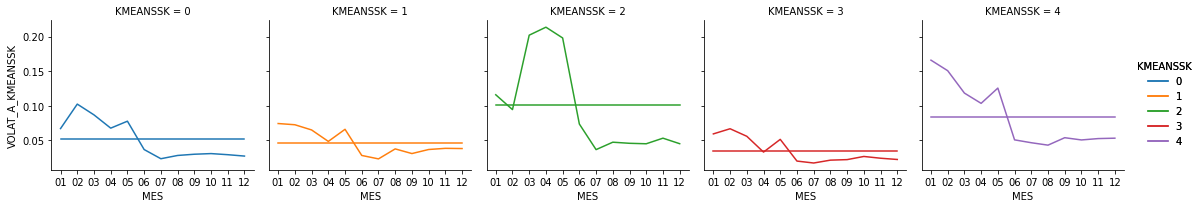

In [51]:
plot3 = sns.FacetGrid(data_model, col='KMEANSSK', hue='KMEANSSK')
plot3 = plot3.map(sns.lineplot, 'MES', 'VOLAT_M_KMEANSSK', ci=None).add_legend()
plot3 = plot3.map(sns.lineplot, 'MES', 'VOLAT_A_KMEANSSK', ci=None).add_legend()

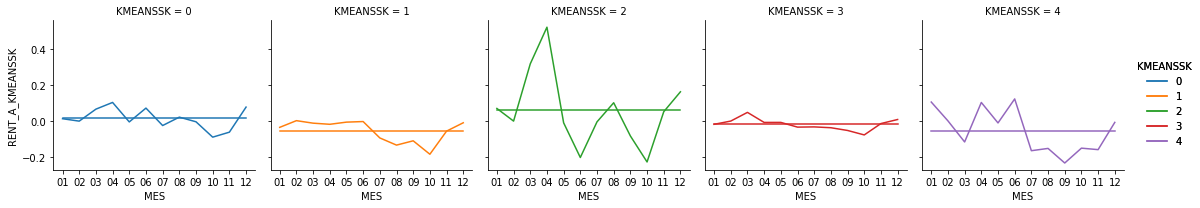

In [52]:
plot3 = sns.FacetGrid(data_model, col='KMEANSSK', hue='KMEANSSK')
plot3 = plot3.map(sns.lineplot, 'MES', 'RENT_M_KMEANSSK', ci=None).add_legend()
plot3 = plot3.map(sns.lineplot, 'MES', 'RENT_A_KMEANSSK', ci=None).add_legend()

In [39]:
data_model[['RENT_A_AJ','VOLAT_A_AJ']].values

array([[ 0.10108548, -0.65175569],
       [-0.18452773,  0.39605779],
       [ 1.12572151,  0.02230133],
       ...,
       [-1.21896596, -0.31328288],
       [ 0.70248845,  0.8495599 ],
       [-0.65164855, -0.46608016]])